### langgraph 기본 그래프 생성

1. State 정의
2. 노드 정의
3. 그래프 정의
4. 그래프 컴파일
5. 그래프 시각화

In [ ]:
pip install langgraph

In [ ]:
pip install langchain_teddynote

In [1]:
# State정의(아래는 형태를 적어놓았을뿐 실제값이나 변수를 입력하여 작성한것은 아님)

from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context : Annotated[List[Document], operator.add]  # 리스트는 애드가 가능
    answer : Annotated[List[Document], operator.add]
    question : Annotated[str,"user question"]          # 문자열에는 애드가 안되니 그냥 정의문을 써둠둠
    sql_query : Annotated[str,"sql query"]
    binary_score : Annotated[str,"binary score yes or no"]

In [6]:
# 노드정의(아래는 형태를 적어 놓았을뿐 실제값이나 변수를 입력하여 작서한것은 아님)
# 노드는 기본적으로 함수구조로 정의한다.

def retrive(state:GraphState) -> GraphState:
    # retrive : 검색 기능 노드
    documents = "검색된 문서"
    return {"context" : documents}   # 입력도 state고 출력도 state이지만 key/value형태로 해도 된다 사실상 같은거다

def rewrite_query(state:GraphState) -> GraphState:
    # Query Transform : 쿼리 재작성
    documents = "검색된 문서"
    return GraphState(context=documents) # 이렇게 반환을 하는것이 정석같은거니 이구조가 좋다

def llm_gpt_execute(state:GraphState) -> GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)

def llm_claude_execute(state:GraphState) -> GraphState:
    # LLM 실행
    answer = "Claude 생성된 답변"
    return GraphState(answer=answer)

def relevance_check(state:GraphState) -> GraphState:
    # Relevance Check : 관련성 확인
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)

def sum_up(state:GraphState) -> GraphState:
    # sum_up : 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)

def search_on_web(state:GraphState) -> GraphState:
    # Search on web : 웹 검색
    documents = state["context"] = "기존문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)

def get_table_info(state:GraphState) -> GraphState:
    # get table info : 테이블 정보 가져오기
    table_info = "테이블 정보"
    return GraphState(context=table_info)

def generate_sql_query(state : GraphState) -> GraphState:
    # Make SQL Query : SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

def execute_sql_query(state : GraphState) -> GraphState:
    # Execute SQL Query : SQL 쿼리 실행
    sql_result = "SQL 결과"
    return GraphState(context=sql_result)

def validate_sql_query(state : GraphState) -> GraphState:
    # Validate SQL Query : SQL 쿼리 검증
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)

def handle_error(stest:GraphState) -> GraphState:
    # Error handling : 에러처리
    error = "에러 발생"
    return GraphState(context=error)

def decision(state:GraphState) -> GraphState:
    # 의사결정
    decision = "결정"
    return decision

### 1. 가장간단한 구조인 conventional RAG

In [ ]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

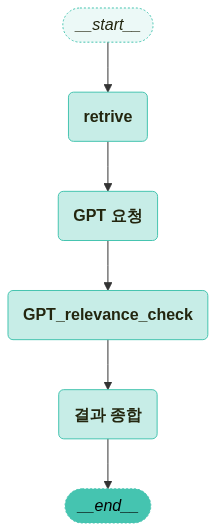

In [ ]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("결과 종합",END)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 2. 1번의 기본 conventional RAG에 재검색 하는 로직 추가

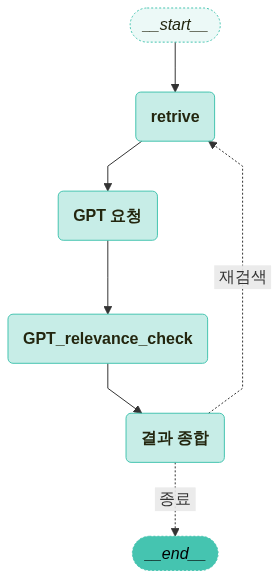

In [ ]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",
    decision,
    {
        "재검색" : "retrive",
        "종료" : END,
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 3. 멀티 LLM 로직

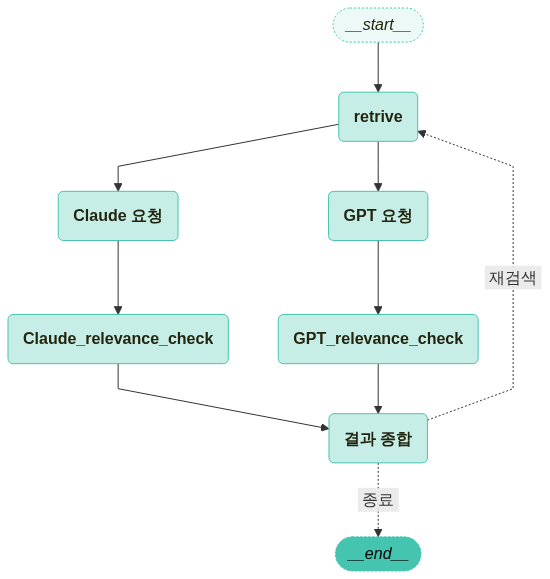

In [7]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("Claude 요청",llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("retrive","Claude 요청")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("Claude 요청","Claude_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("Claude_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",
    decision,
    {
        "재검색" : "retrive",
        "종료" : END,
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 4. 3번에 쿼리재작성 노드 추가

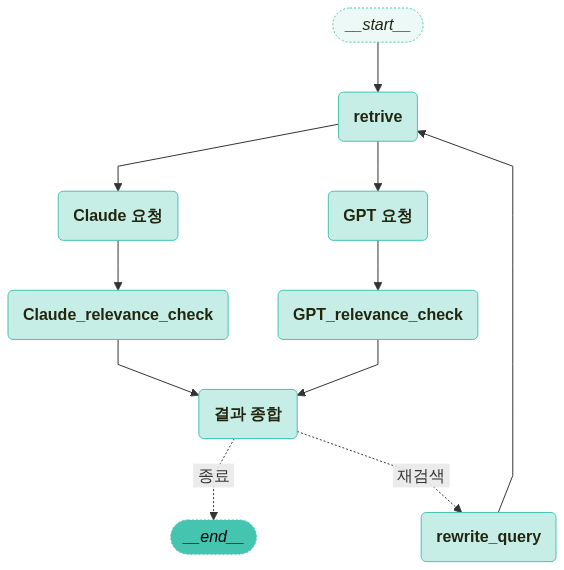

In [8]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("retrive", retrive)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("Claude 요청",llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("retrive","GPT 요청")
workflow.add_edge("retrive","Claude 요청")
workflow.add_edge("rewrite_query","retrive")
workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("Claude 요청","Claude_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("Claude_relevance_check","결과 종합")

workflow.add_conditional_edges(
    "결과 종합",  # 관련성 체크 노드에서 나온 결과물을 is_relevant 함수에 전달 합니다.
    decision,
    {
        "재검색" : "rewrite_query", # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
        "종료" : END,   # 관련성이 없으면 종료 합니다. 
    },
)

workflow.set_entry_point("retrive")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### 5. SQL RAG

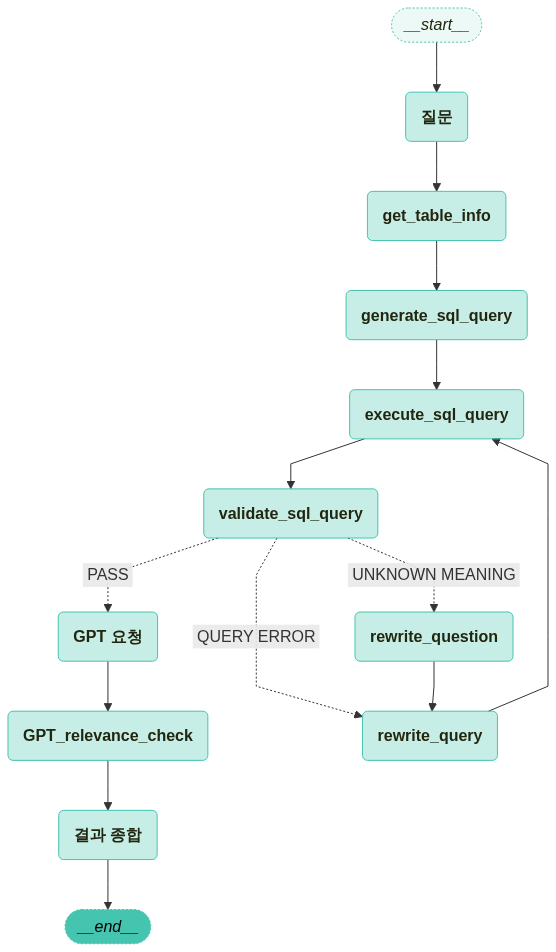

In [12]:
#langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가 합니다.
workflow.add_node("질문", retrive)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query",generate_sql_query)
workflow.add_node("execute_sql_query",execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT 요청",llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드를 연결 합니다.
workflow.add_edge("질문","get_table_info")
workflow.add_edge("get_table_info","generate_sql_query")
workflow.add_edge("generate_sql_query","execute_sql_query")
workflow.add_edge("execute_sql_query","validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",  # 관련성 체크 노드에서 나온 결과물을 is_relevant 함수에 전달 합니다.
    decision,
    {
        "UNKNOWN MEANING" : "rewrite_question",
        "QUERY ERROR" : "rewrite_query",
        "PASS" : "GPT 요청",
    },
)

workflow.add_edge("rewrite_question","rewrite_query")
workflow.add_edge("rewrite_query","execute_sql_query")

workflow.add_edge("GPT 요청","GPT_relevance_check")
workflow.add_edge("GPT_relevance_check","결과 종합")
workflow.add_edge("결과 종합",END)

workflow.set_entry_point("질문")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

### RAG구현하기(점점 기능 늘리면서 langgraph 사용)

In [1]:
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv()

True

In [6]:
pip install langchain langchain-community pypdf faiss-cpu

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   --------- ------------------------------ 0.6/2.5 MB 19.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.6/2.5 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.5 MB 20.1 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 16.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/304.2 kB ? eta -:--:--
   ---------------------------------------- 304.2/304.2 kB 9.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.0 MB ? eta -:--:--
   --- ------------------------------------ 1.3/15.0 MB 28.9 MB/s eta 0:00:01
   ------- -------------------------------- 2.6/15.0 MB 33.6 MB/s eta 0:00:01
   ----------- ---------------------------- 4.4/15.0 MB 31.0 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/15.0 MB 33.8 MB/s eta 0:00:01
   --------------------- ------------------ 8.1/15.0 MB 37.3 MB/s eta 0:00:01
   ---------

In [7]:
# pdf 문서 로드
from rag.pdf import PDFRetrievalChain

ModuleNotFoundError: No module named 'rag'